In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne 

# Parameters ###################################################################

max_firing_rate = 5         # (per second)
mean_firing_threshold = 0.5 # [Theta] (mV), half of the maximum response of the pop

# Sigmoid slopes (mV^-1) 
r_0 = 0.56
r_1 = 0.56
r_2 = 0.56

# Inverse time constants (s^-1)
# Smaller value, slower effect.. 
a = 100 # excitatory 
ad = 50 # long-range excitatory
b = 50  # inhibitory

# Maximum amplitudes of post-synaptic potential (PSPs) (mV)
A = 3.25 # excitatory
B = 22.0 # inhibitory

# Connectivity constants
C = 135         # Global synaptic connectivity
C1 = C          # Connectivity between Pyramidal and Excitatory
C2 = 0.8 * C    # Connectivity between Excitatory and Pyramidal
C3 = 0.25 * C   # Connectivity between Pyramidal and Inhibitory
C4 = 0.25 * C   # Connectivity between Inhibitory and Pyramidal

# Modified Jansen & Rit Parameters 
# Cholinergic modulation of inhibitory circuits and the segregation/integration balance

# Both as multiples of C
alpha = 0 # excitatory gain, connectivity between long-range pyramidal 
beta = 0  # inhibitory gain, connectibity between inhibitory and excitatory interneuron (short range)

# Structural Connectivity Matrix
num_nodes = 100
SC = np.genfromtxt('SC_in_Schaefer-100.csv', delimiter=',')

max_firing_rate = 5
mean_firing_threshold = 6

Hyperparameters

A, B, a, b, ad 

But IPSPs (inhibitory post synaptic potential) B, b have longer amplitude and latency than ESPSs (excitatory post synaptic
potential), A, a based on their biological structure.

B > A. b < a (inverse time constant)

C

max_firing_rate, mean_firing_threshold

r_0, r_1, r_2

In [3]:
# Sigmoid Function - transforms the postynaptic potential (PSP) into an average pulse density 
# v is the average psp, r is the slope of the sigmoid function
# def sigmoid(v, r):
#     return max_firing_rate / (1 + np.exp(r * (mean_firing_threshold - v))) # output is num_nodes x 1 

def sigmoid(v,r):
    return max_firing_rate  / (1 + np.exp(r * (mean_firing_threshold - v)))

# PSPs ###################################################################
# t is average pulse density/spike rate 

# Excitatory PSP
def epsp(t):
    if t < 0:
        return 0
    else:
        return A * a * t * np.exp(-a * t)
    
# Inhibitory PSP
def ipsp(t):
    if t < 0:
        return 0
    else:
        return B * b * t * np.exp(-b * t)

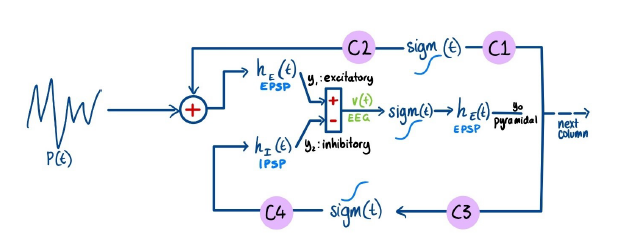

In [4]:
# x3 is a vector of size num_nodes by 1
def calculate_zi(x3):
    return np.dot(SC, x3) # output num_nodes x 1

# System of Equations ########################################################  

norm = np.sqrt(np.sum(SC, axis = 1) * np.sum(SC, axis = 0))
# Expanded Jansen & Rit Model 
def system_of_equations(x):
    x0, y0, x1, y1, x2, y2, x3, y3 = x

    # Noise  - uncorrelated Gaussian-distributed noise with mean 2 and standard deviation 2
    noise = np.random.normal(2,2,num_nodes) # produces a num_nodes x 1 vector 

    dx0dt = y0
    dy0dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y0 - a**2 * x0
    dx1dt = y1
    dy1dt = A * a * (noise + sigmoid(C1 * x0 - C * beta * x2, r_1)) - 2 * a * y1 - a**2 * x1
    dx2dt = y2
    dy2dt = B * b * sigmoid(C3 * x0, r_2) - 2 * b * y2 - b**2 * x2
    dx3dt = y3
    dy3dt = A * ad * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * ad * y3 - ad**2 * x3
    return [dx0dt, dy0dt, dx1dt, dy1dt, dx2dt, dy2dt, dx3dt, dy3dt] # num_nodes x 8 matrix output 


TR - repetition time.  
Sampling frequency = 1 / TR. 

Functional MRI data were collected using a T2*-weighted echoplanar imaging (EPI) sequence with the following parameters: slice thickness=4 mm, 34 slices, TR=2 s, TE=30 ms, flip angle=90°, matrix 64×64, FOV=192 mm, oblique slice orientation.

So, bold sampling frequency = 1/2 = 0.5 Hz. (i.e. one data point acquired every 2 seconds)

Fix downsampling so sampling freq matches empirical EEG (1000 Hz) or BOLD (0.5 Hz) 

Sampling freq = 1 / dt = 1000 Hz

Downsampling to use = current sampling freq / intended sampling freq


In [5]:
eeg_freq = 1000
bold_freq = 0.5

# Simulation parameters
dt = 0.001 # Step size
transient = 60  # Simulation duration for stabilizing (with Euler method)
sim_length = 600 # Simulation time points (to plot)

downsample_eeg = (1 / dt) / eeg_freq
downsample_bold = (1 / dt) / bold_freq

# Initial conditions
initial_conditions = np.ones((8, num_nodes)) * 0.5

total_sims = int((transient + sim_length/ dt) - 1)
total_downsampled_sims = int(total_sims / downsample_eeg)

# Array to store results
sol = np.zeros((total_downsampled_sims, 8, num_nodes))
sol[0,:,:] = np.copy(initial_conditions) #First set of initial conditions
y_temp = np.copy(initial_conditions)

# Run simulation using Euler method
for i in range(1, total_sims - 1):
    # sol[i] = sol[i-1] + dt * np.array(system_of_equations(sol[i-1])) # Doing it this way makes it abt 30 secs faster, good for optimising model
    y_temp += dt * np.array(system_of_equations(y_temp))
    if i % downsample_eeg == 0:
        sol[int(i/downsample_eeg) - 1] = np.copy(y_temp)

KeyboardInterrupt: 

In [5]:
x1 = sol[:,2]
x2 = sol[:,4]
x3 = np.apply_along_axis(calculate_zi, axis=1, arr=sol[:, 6])

In [5]:
from sklearn import datasets

# Normalise each channel for standard deviation ?
# eeg_freq is 1000Hz, i.e. 1000 points per second. So 2000 points in 2 seconds. 
time_points_in_2_secs = int(2 * eeg_freq)

# With vectorised operations, Calculate V_T_sim directly for the desired time points
V_T_sim = C2 * x1[-time_points_in_2_secs:] - C4 * x2[-time_points_in_2_secs:] + C * alpha * x3[-time_points_in_2_secs:]

%store V_T_sim

NameError: name 'x1' is not defined

In [ ]:
# # This is needed for the BOLD model 
# %store x1
# %store x2
# %store x3

600059


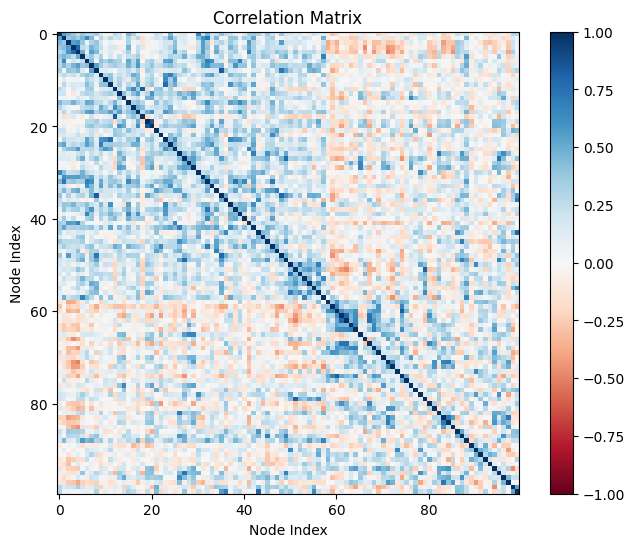

Pearson correlation coefficient: 0.34912341138815767


In [10]:
# from scipy import signal
# %run BOLD_Model.ipynb

# # As J&R model already run with downsampling for eeg, need to adjust downsampling rate
# adjusted_downsample = int(downsample_bold / downsample_eeg)

# # Initial conditions
# initial_conditions = np.array([[0.1, 1, 1, 1]] * num_nodes).T

# total_bold_downsampled_sims = int(total_downsampled_sims / adjusted_downsample)

# # Array to store results
# BOLD_vars = np.zeros((total_downsampled_sims + 1 , 4, num_nodes))
# BOLD_vars[0] = initial_conditions
# BOLD_temp = np.copy(initial_conditions)

# # Run simulation using Euler method, NOTE - total_downsampled_sims is the number of timepoints we have firing rates for 
# for i in range(total_downsampled_sims):
#     # dt has to match the sampling frew of what you pass into the BOLD model, in this case it is the data already 
#     # downsampled by eeg freq
#     BOLD_temp += (1/eeg_freq) * np.array(balloon_windkessel_ode(BOLD_temp, i))
#     BOLD_vars[i] = np.copy(BOLD_temp)

# #Downsample by adjusted rate
# BOLD_vars = BOLD_vars[::adjusted_downsample]

# # Take final half of results as simulation points
# BOLD_sim_length = int(1/2 * total_bold_downsampled_sims)
# BOLD_vars_result = BOLD_vars[-BOLD_sim_length:]

# # Initialize BOLD array - will only take the final BOLD_sim_length timepoints
# BOLD_array = np.zeros((BOLD_sim_length - 1, num_nodes))

# # Generate BOLD array
# q = BOLD_vars_result[:-1, 3, :]
# v = BOLD_vars_result[:-1, 2, :]

# BOLD_array = V_0 * (k1 * (1 - q) + k2 * (1 - (q / v)) + k3 * (1 - v))

# # Pass BOLD signals through bandpass filter

# Fmin, Fmax = 0.01, 0.1
# tr = 1 / bold_freq
# a0, b0 = signal.bessel(3, [2 * tr * Fmin, 2 * tr * Fmax], btype = 'bandpass')
# BOLDfilt = signal.filtfilt(a0, b0, BOLD_array[:,:], axis = 0)

# # Calculate the FC from the filtered BOLD signal

# FC_matrix = np.corrcoef(BOLDfilt.T)

# fig = plt.figure(figsize=(8, 6))
# plt.imshow(FC_matrix, cmap='RdBu', vmin=-1, vmax=1)
# plt.colorbar()
# plt.title('Correlation Matrix')
# plt.xlabel('Node Index')
# plt.ylabel('Node Index')
# plt.show()
# plt.close(fig)


In [ ]:

# # Calculate goodness of fit for BOLD data ####################################################

# # Load the empricical (averaged) FC matrix
# observed_fc_matrix = np.load("fc_matrices/averaged_fc_matrix.npy")

# # Flatten both and use pearson correlation to calculate goodness of fit
# pearson_corr = np.corrcoef(np.ravel(FC_matrix), np.ravel(observed_fc_matrix))[0, 1]

# print("Pearson correlation coefficient:", pearson_corr)

In [1]:
import pickle
import skopt.plots as skplt
%run OptimiseFunctions.py

with open('eeg_res.pkl', 'rb') as f:
    eeg_res = pickle.load(f)


In [2]:
eeg_res

          fun: -0.7111382440188554
            x: [4, 15, 150, 50, 74, 75, 0.12853997939556028, 0.11814344383591964, 0.1308982503060793, 0.90108637455631, 0.5]
    func_vals: [-5.250e-01 -5.678e-01 ... -5.804e-01 -6.474e-01]
      x_iters: [[9, 24, 132, 134, 46, 39, 0.5368253363166899, 0.2956277701957784, 0.03157449689094228, 0.02055144566883083, 0.18804751727970404], [2, 19, 81, 81, 47, 64, 0.41700343192326084, 0.6344560095485579, 0.4036348857314137, 0.919812218400805, 0.09423812572639148], [8, 22, 92, 125, 44, 63, 0.5191518939255283, 0.25658372710272487, 0.8417482212667345, 0.9751755017411463, 0.18112375976704173], [11, 29, 124, 95, 57, 42, 0.9788529639252033, 0.11656894930987152, 0.2645393478835279, 0.6258885899120972, 0.1770844599121553], [9, 16, 111, 95, 43, 69, 0.4101053899608481, 0.5095858351934122, 0.4603275389710412, 0.08968853606396822, 0.16144290923108864], [6, 23, 91, 76, 28, 64, 0.8125914678868484, 0.9585388913914294, 0.9713233285889541, 0.5757502722010095, 0.2946981516676

NameError: name 'plt' is not defined

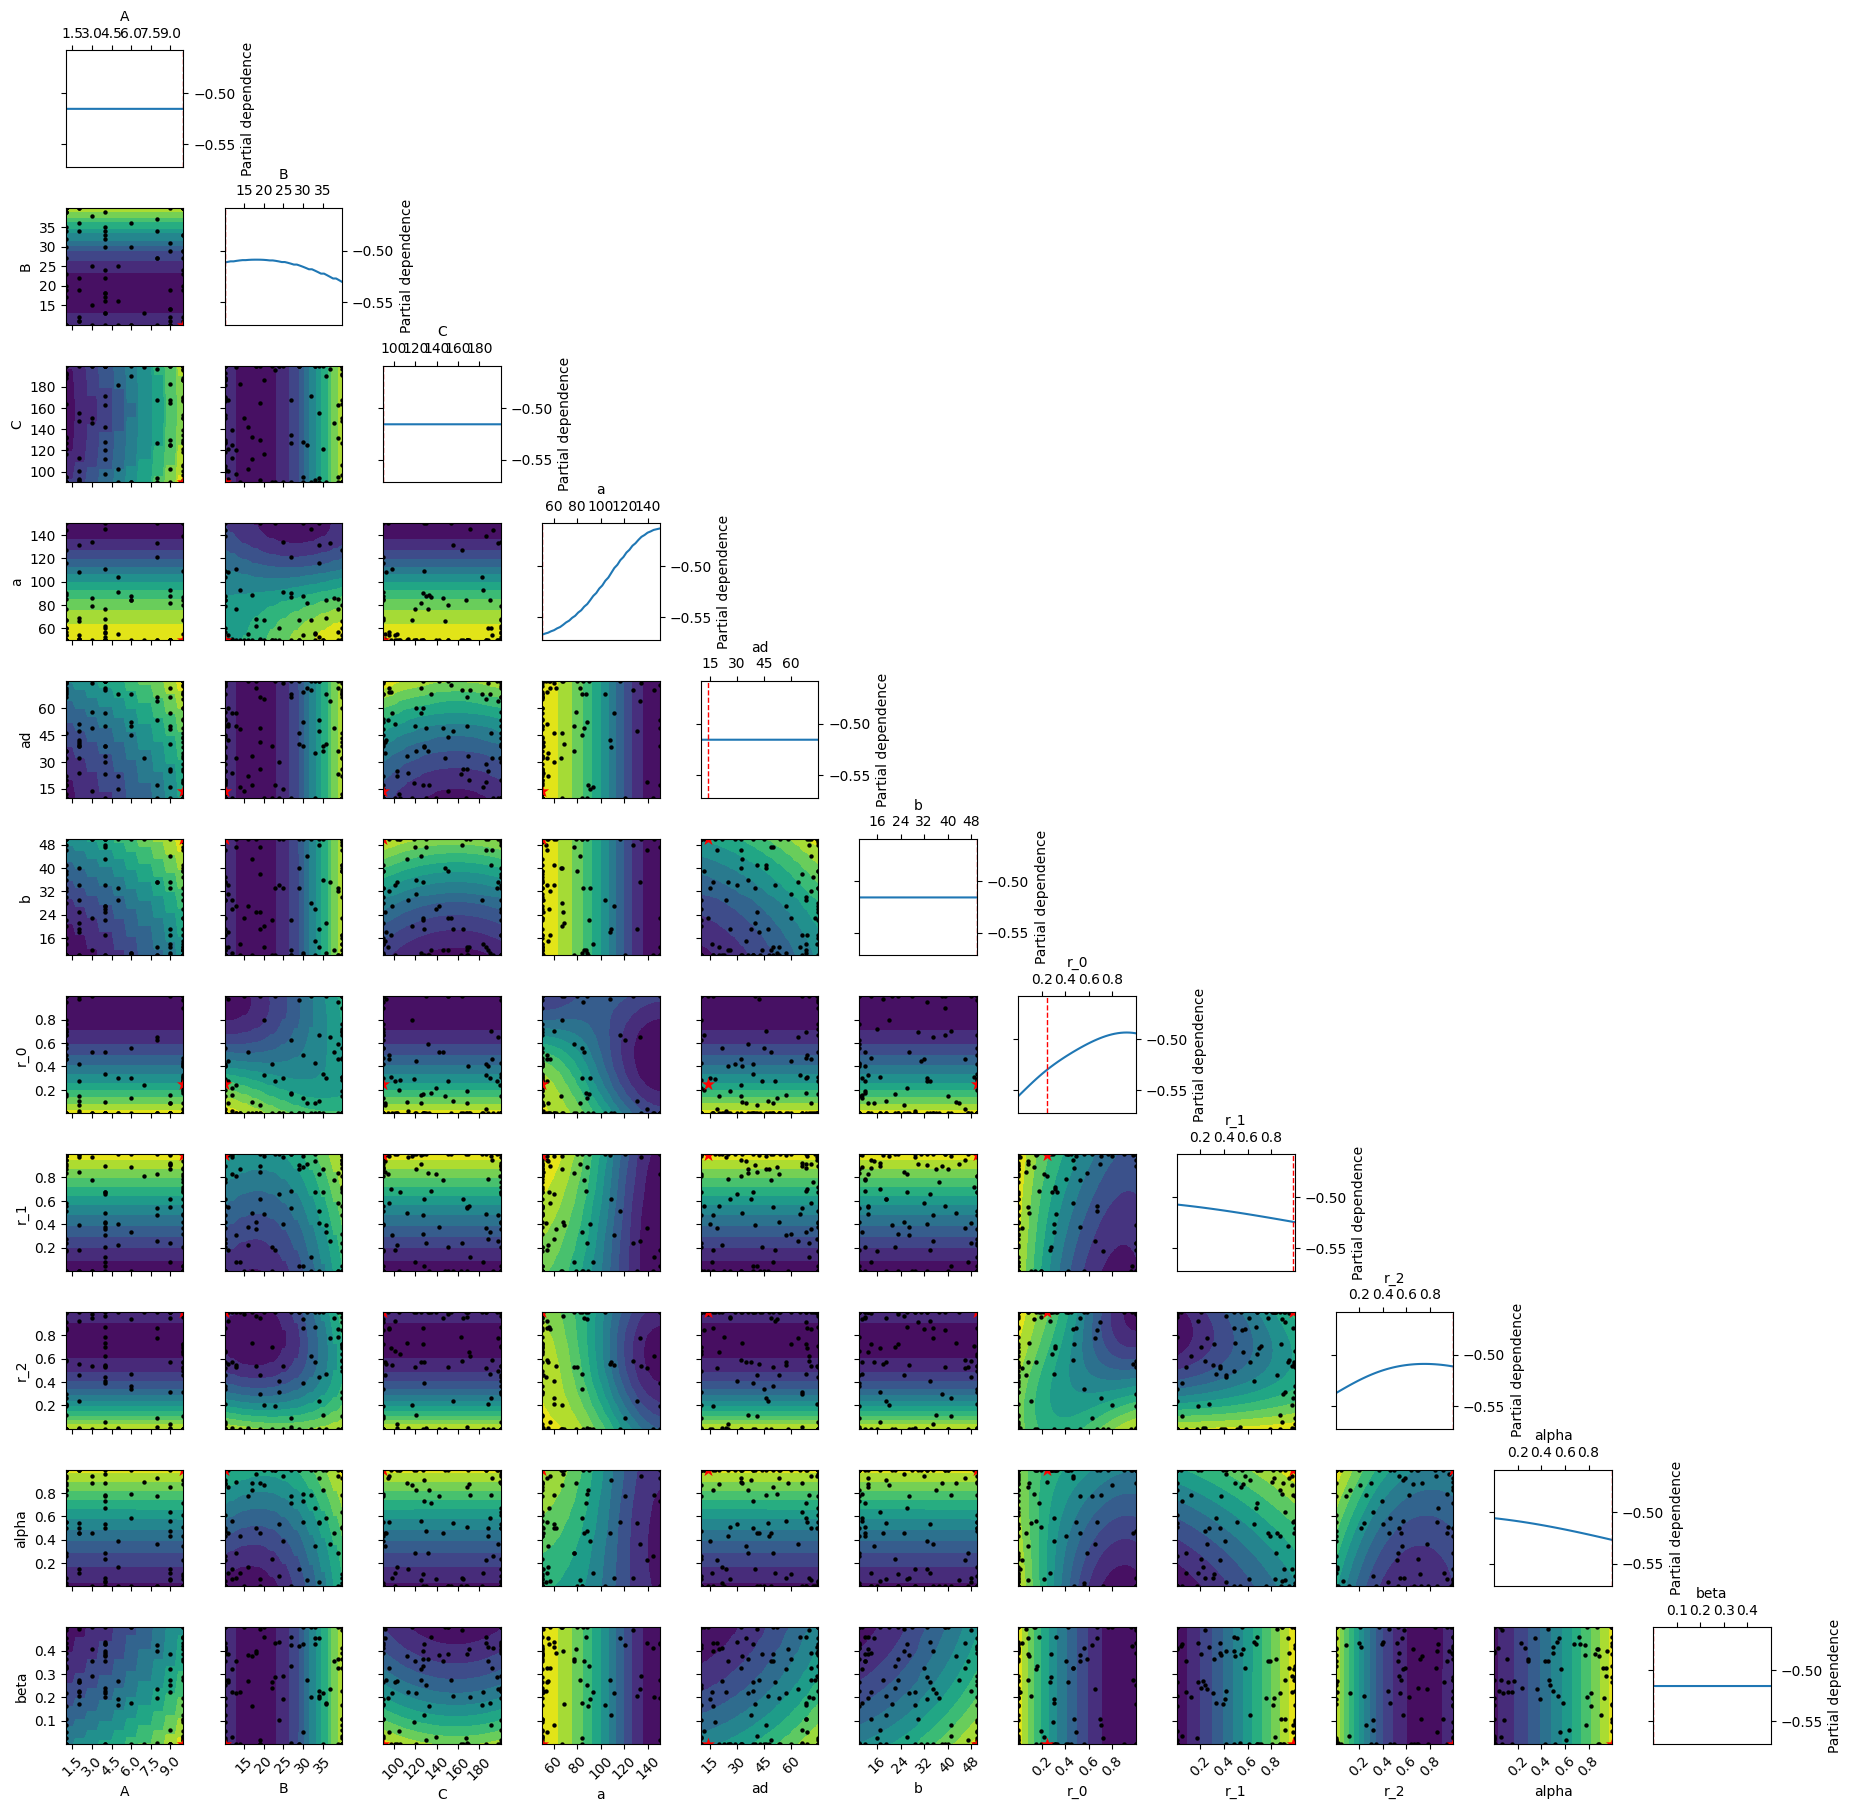

In [2]:
import pickle
import skopt.plots as skplt
%run OptimiseFunctions.py

with open('eeg_res_control_120_gp_1.pkl', 'rb') as f:
    eeg_res_control_120_gp_1 = pickle.load(f)

skplt.plot_objective(eeg_res_control_120_gp_1, levels=11, n_samples=600)

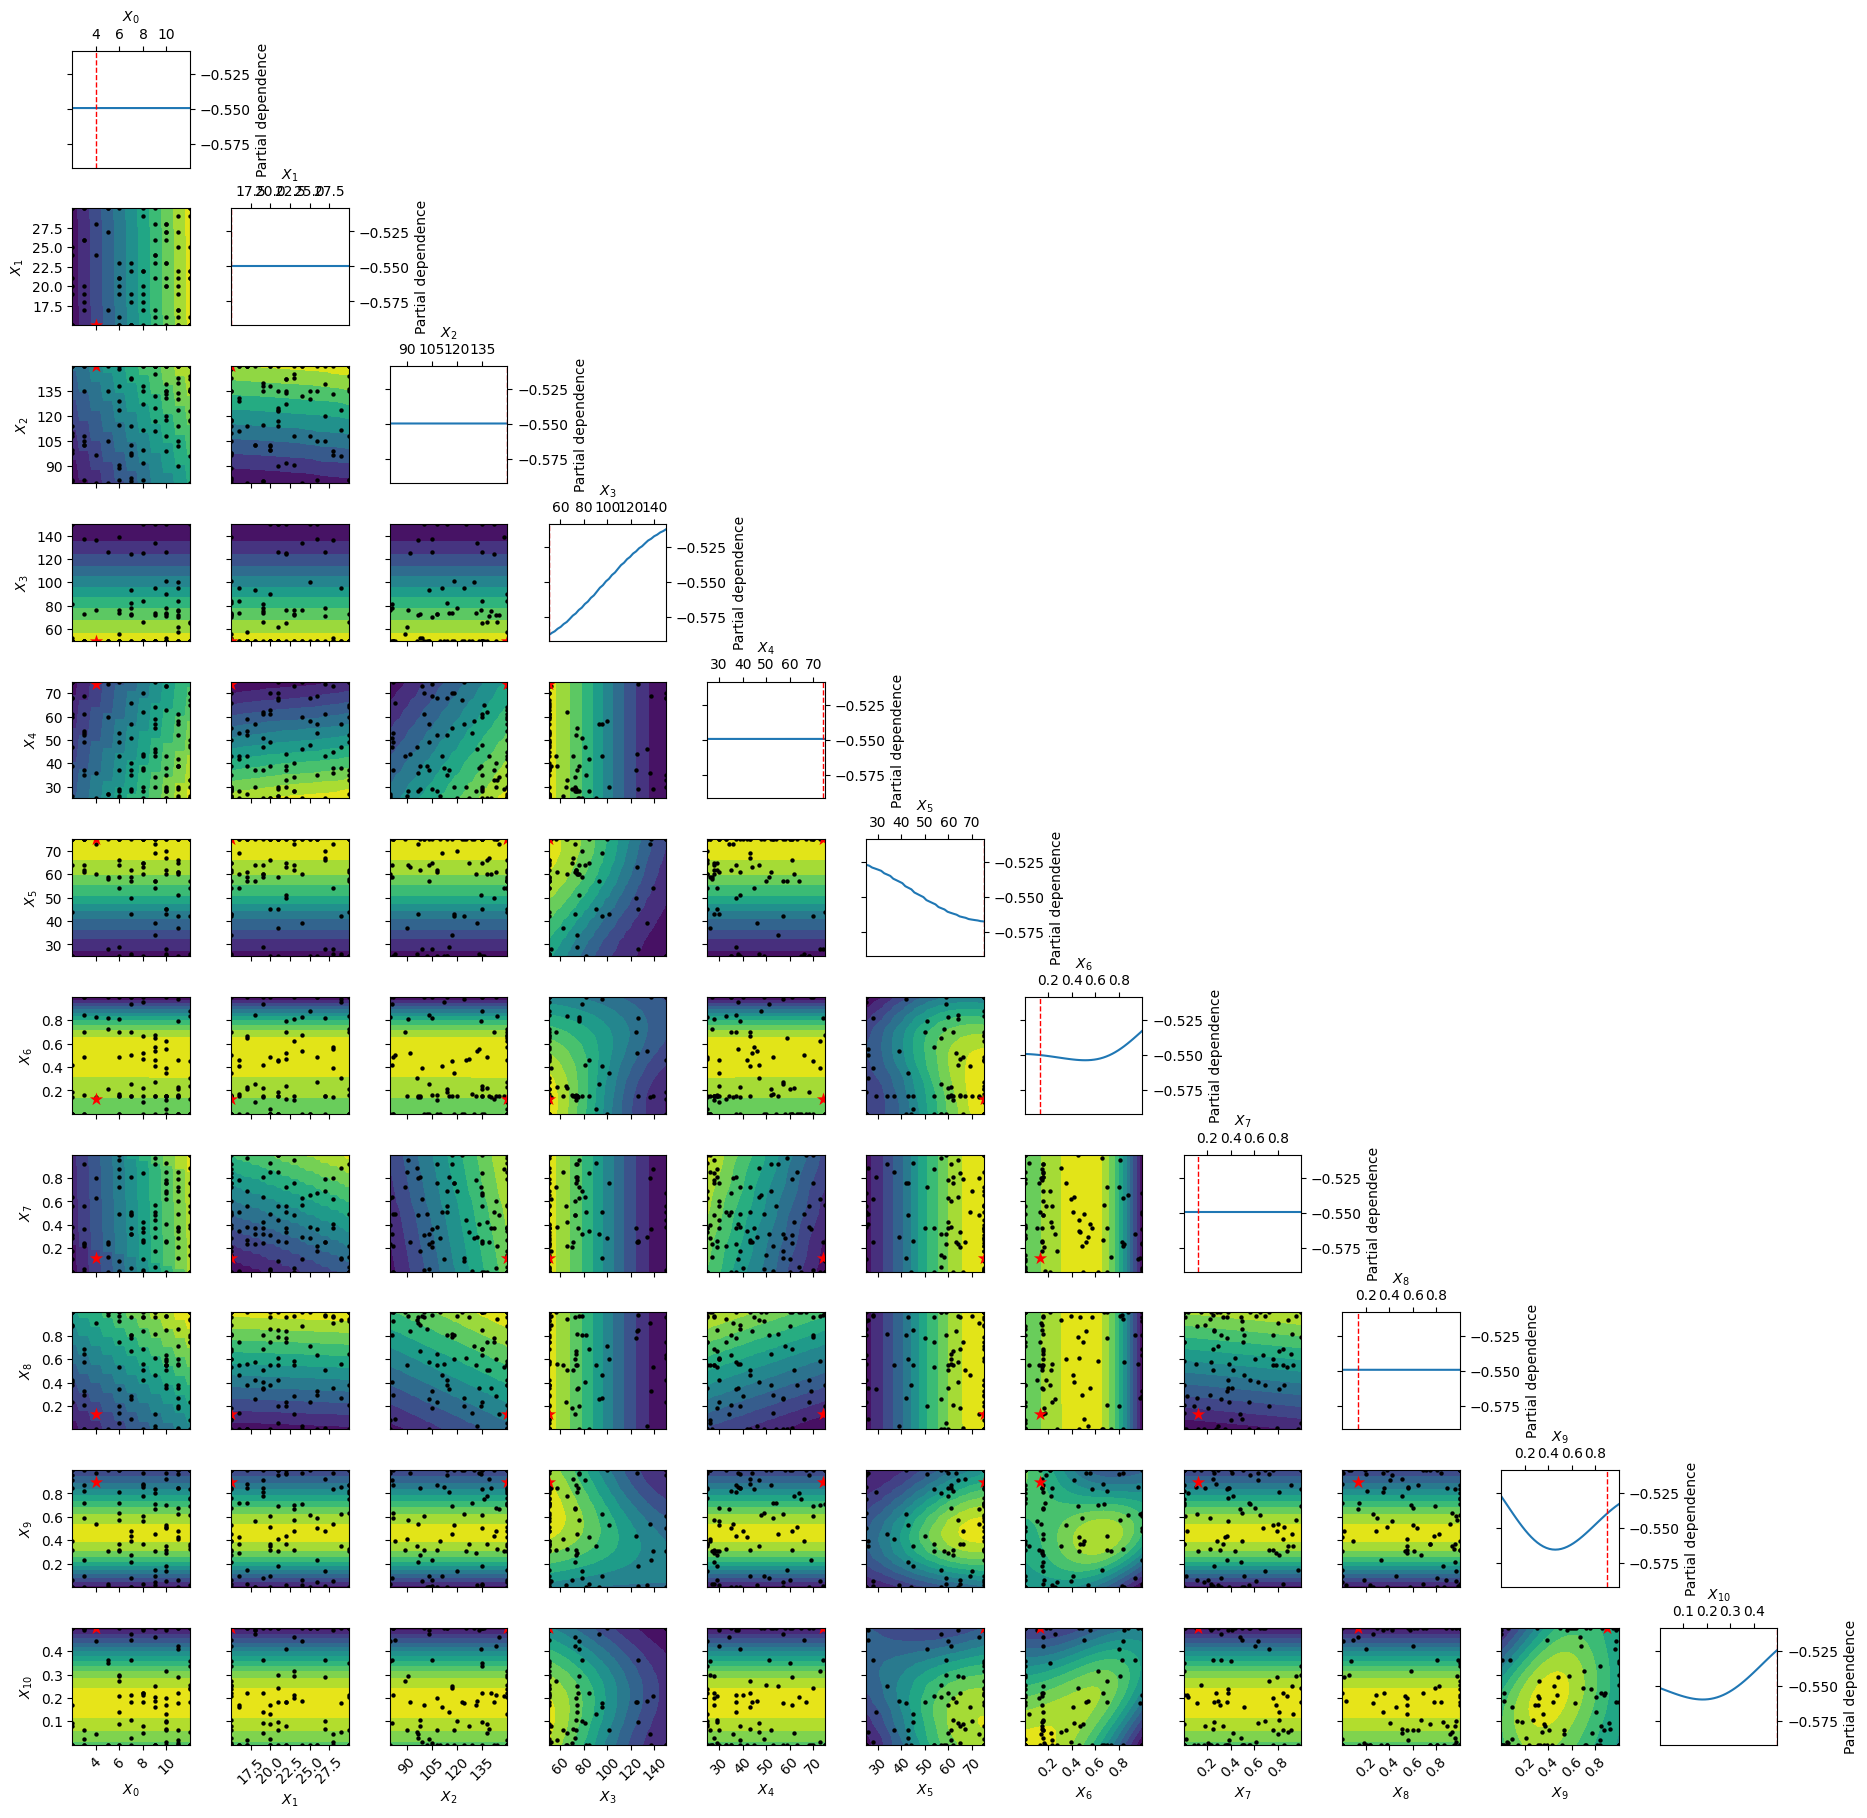

In [ ]:
import pickle
import skopt.plots as skplt
%run OptimiseFunctions.py

with open('eeg_res_schiz_120_gp_2.pkl', 'rb') as f:
    eeg_res_schiz_120_gp_2 = pickle.load(f)

skplt.plot_objective(eeg_res_schiz_120_gp_2, levels=11, n_samples=600)

NameError: name 'plt' is not defined

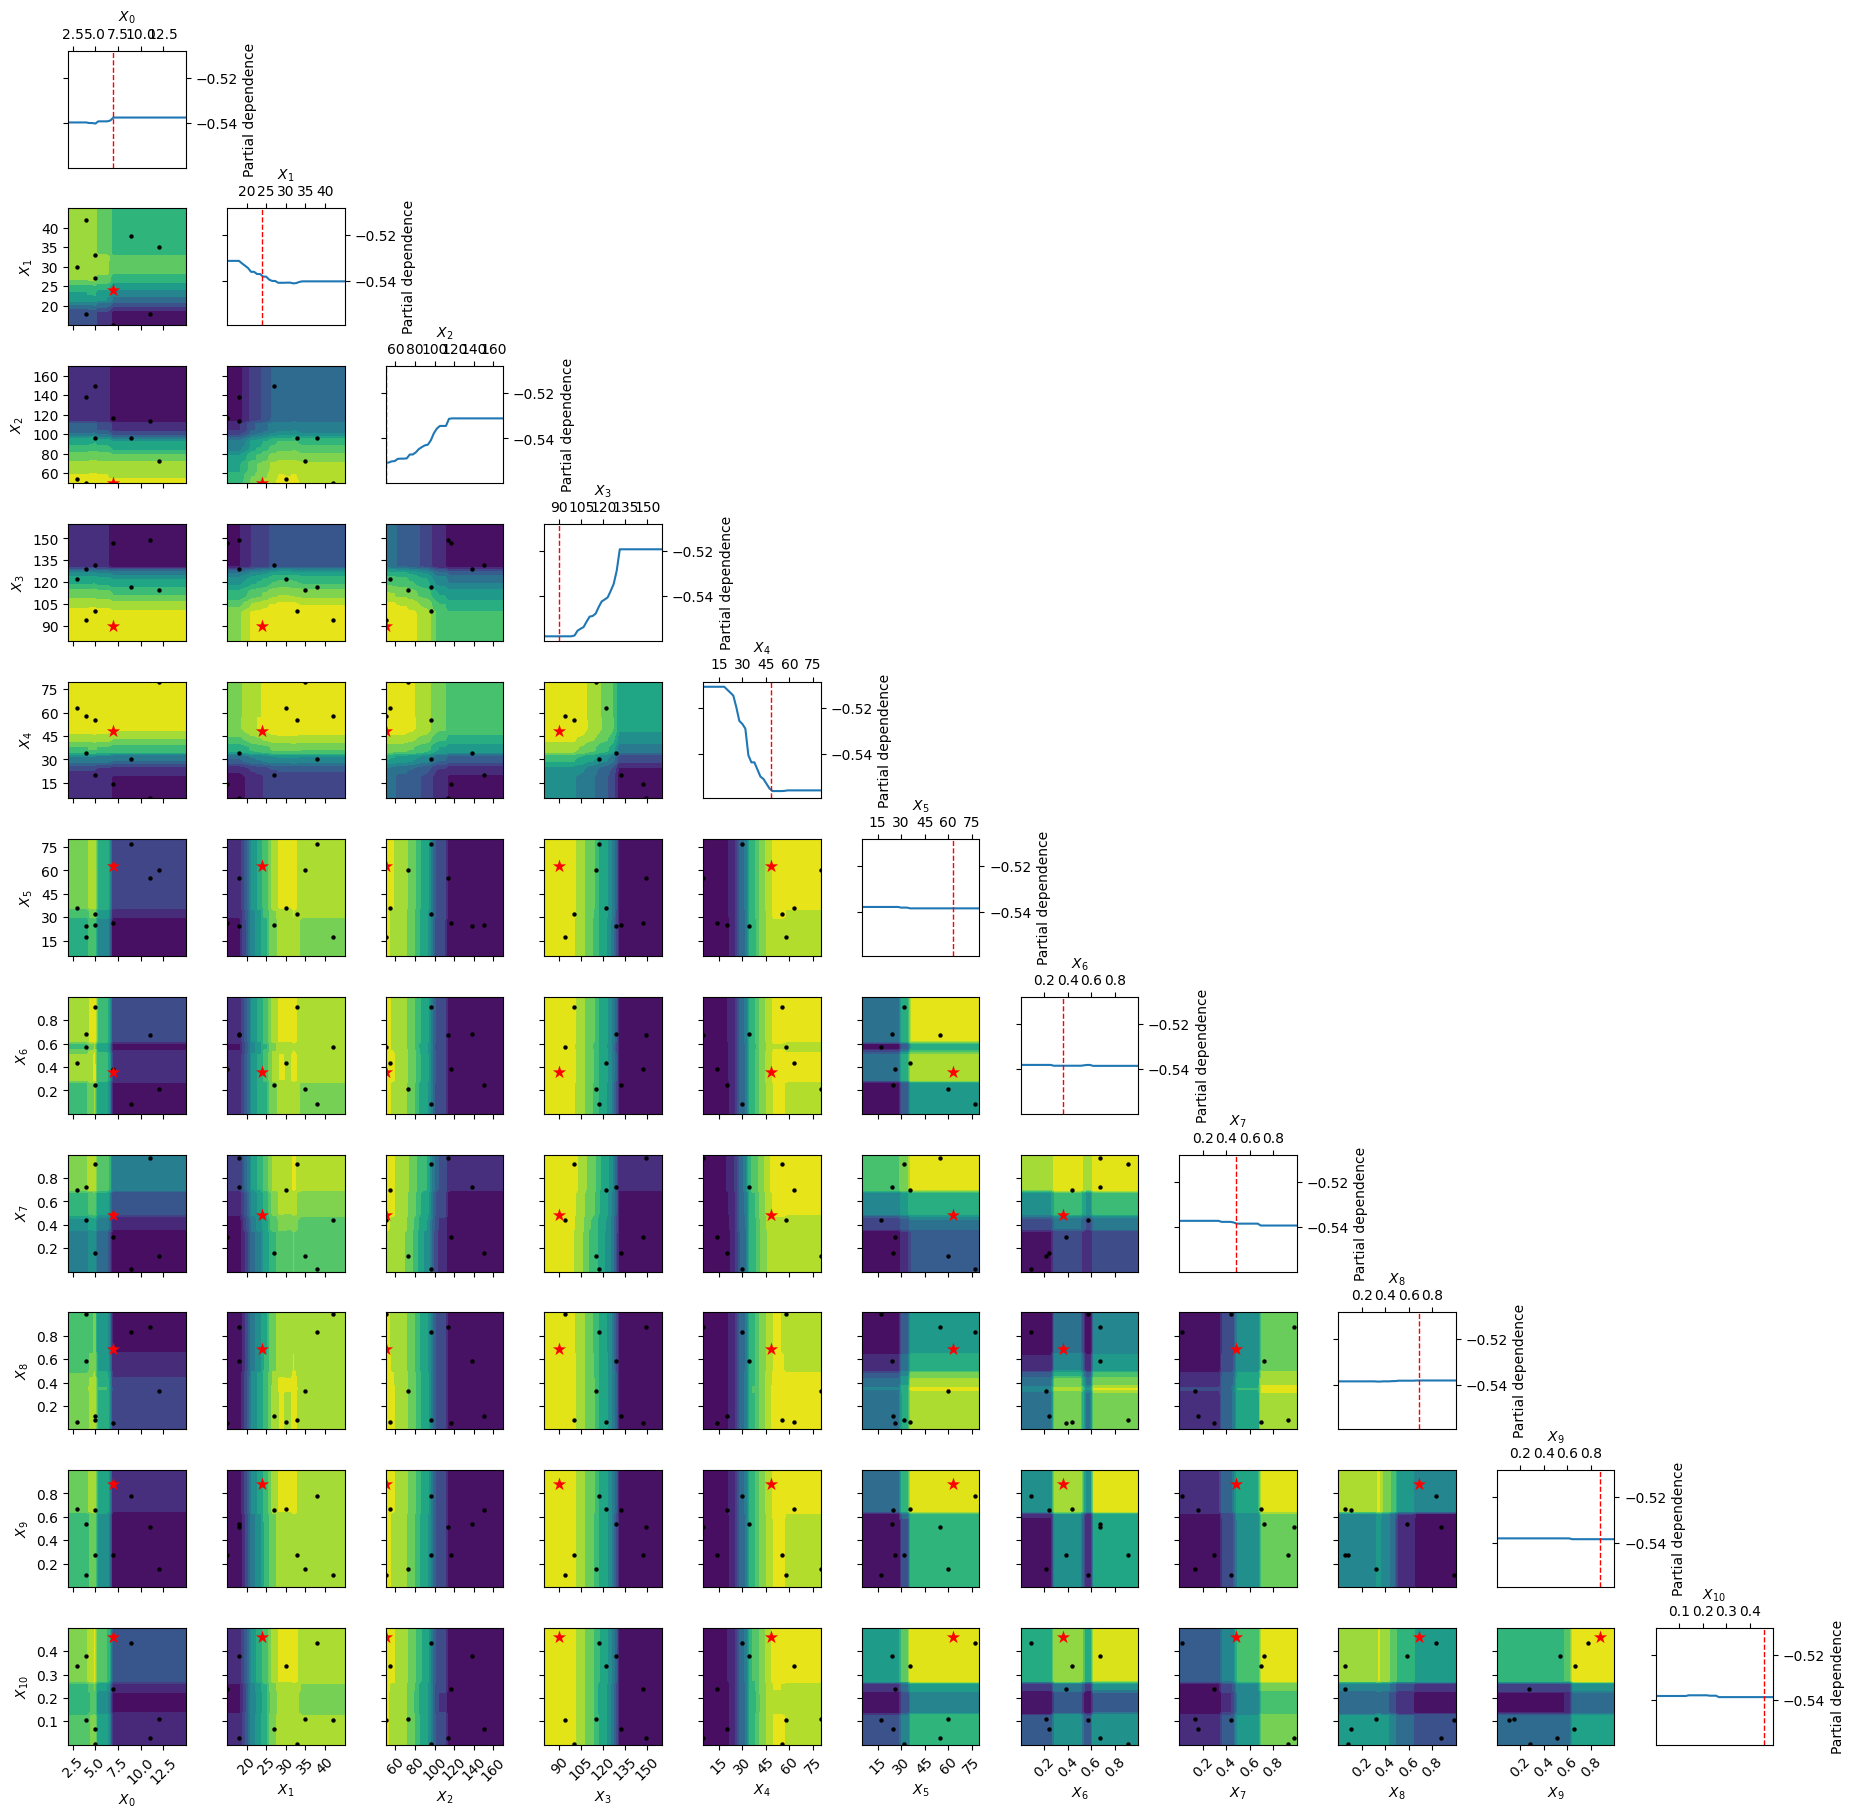

In [1]:
import pickle
import skopt.plots as skplt
%run OptimiseFunctions.py

with open('eeg_res_forest_schiz.pkl', 'rb') as f:
    eeg_res_forest_schiz = pickle.load(f)

skplt.plot_objective(eeg_res_forest_schiz, levels=11, n_samples=400)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

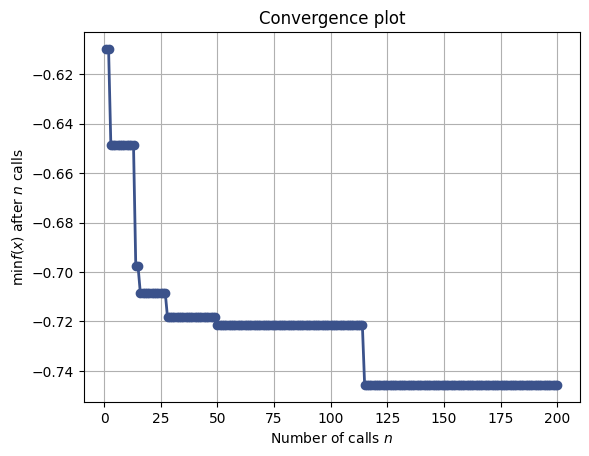

In [3]:
import pickle
import skopt.plots as skplt
%run OptimiseFunctions.py

with open('eeg_res_schiz_1_gp.pkl', 'rb') as f:
    eeg_res_schiz_1 = pickle.load(f)

from skopt.plots import plot_convergence

plot_convergence(eeg_res_schiz_1)


<Axes: >

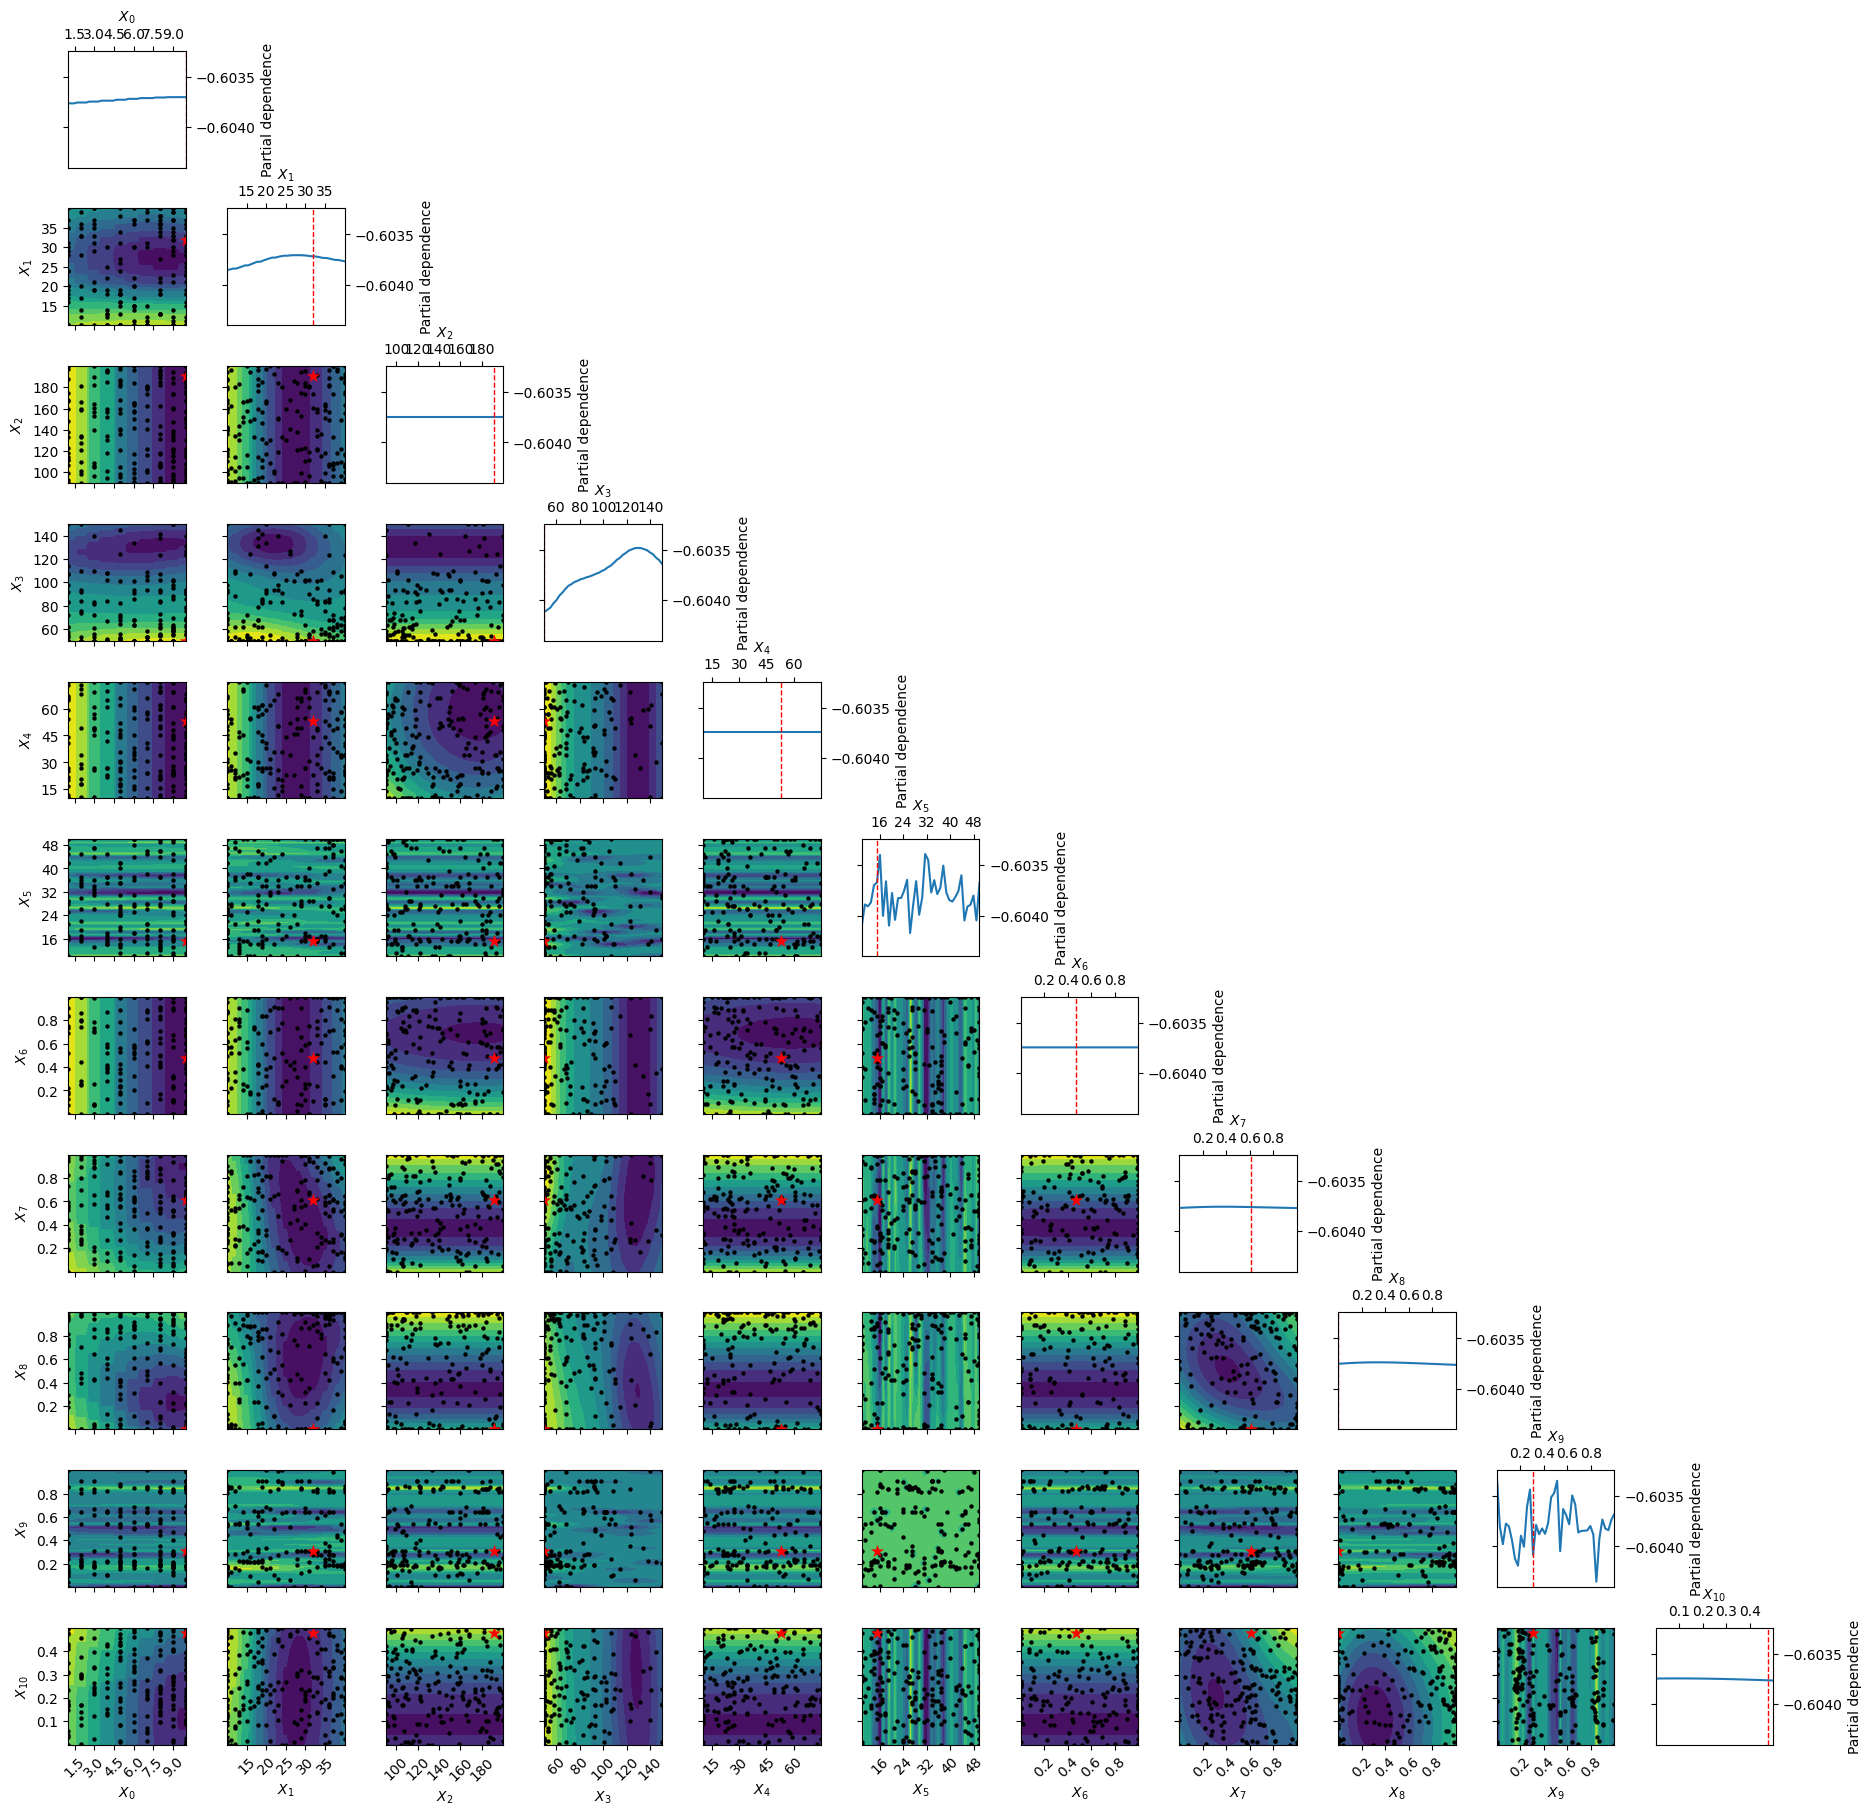

In [1]:
import pickle
import skopt.plots as skplt
%run OptimiseFunctions.py

with open('eeg_res_schiz_1_gp.pkl', 'rb') as f:
    eeg_res_schiz_1 = pickle.load(f)

skplt.plot_objective(eeg_res_schiz_1, levels=11, n_samples=1100)